## CS 476 Assignment 4
#### Jeongseop Yi (Patrick), j22yi
#### Q3

In [336]:
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [337]:
# To calculate the true model option price
def blsprice2(S0, K, r, T, sigma):
    ''' Valuation of European option in BSM model Analytical formula.
    '''
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    # if optionType == 'call':
    C_value = (S0 * stats.norm.cdf(d1, 0.0, 1.0) -
               K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    # elif optionType == 'put':
    P_value = (K * np.exp(-r * T) * stats.norm.cdf(-d2, 0.0, 1.0)
               - S0 * stats.norm.cdf(-d1, 0.0, 1.0))
    return (C_value, P_value)

In [338]:
# Volatility surface table
vol_surface = pd.DataFrame(columns=['0.9', '0.95', '1', '1.05', '1.1'], 
                           index=['0.425', '0.695', '1'])
vol_surface['0.9'] = [0.155, 0.157, 0.159]
vol_surface['0.95'] = [0.138, 0.144, 0.149]
vol_surface['1'] = [0.125, 0.133, 0.137]
vol_surface['1.05'] = [0.109, 0.118, 0.127]
vol_surface['1.1'] = [0.103, 0.104, 0.113]
display(vol_surface)

,0.9,0.95,1,1.05,1.1
0.425,0.155,0.138,0.125,0.109,0.103
0.695,0.157,0.144,0.133,0.118,0.104
1,0.159,0.149,0.137,0.127,0.113


In [339]:
# make a list of tuples of the form (strike, maturity, vol)
vol_data = []
for i in range(vol_surface.shape[0]):
    for j in range(vol_surface.shape[1]):
        vol_data.append((float(vol_surface.columns[j]), 
                         float(vol_surface.index[i]), 
                         vol_surface.iloc[i, j]))
vol_data = np.array(vol_data)

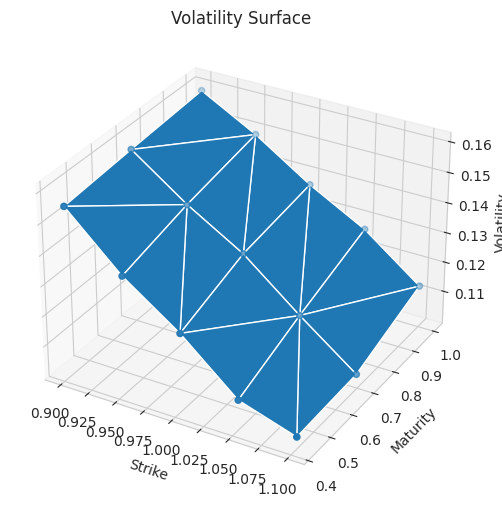

In [340]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(vol_data[:, 0], vol_data[:, 1], vol_data[:, 2], shade=False)
ax.scatter(vol_data[:, 0], vol_data[:, 1], vol_data[:, 2])
plt.xlabel('Strike')
plt.ylabel('Maturity')
ax.set_zlabel('Volatility')
plt.title('Volatility Surface')
plt.show()

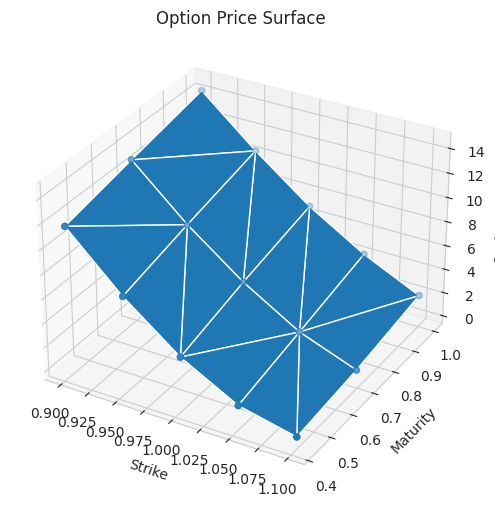

In [341]:
# constants
S0 = 100
r = 0.03

Vmkt = blsprice2(S0, vol_data[:, 0] * S0, r, vol_data[:, 1], vol_data[:, 2])[0]

sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(vol_data[:, 0], vol_data[:, 1], Vmkt, shade=False)
ax.scatter(vol_data[:, 0], vol_data[:, 1], Vmkt)
plt.xlabel('Strike')
plt.ylabel('Maturity')
ax.set_zlabel('Option Price')
plt.title('Option Price Surface')
plt.show()

#### b)

In [342]:
# upstream alpha beta calculation function
def upstream(S, sigma_func, r):
    Splus1 = np.roll(S, -1)
    Splus1[-1] = np.nan
    Sminus1 = np.roll(S, 1)
    Sminus1[0] = np.nan
    sigma = sigma_func(S)

    alpha_cen = (sigma**2*S**2 / ((S - Sminus1) * (Splus1 - Sminus1)) 
                 - (r * S) / (Splus1 - Sminus1))
    beta_cen = (sigma**2*S**2 / ((Splus1 - S) * (Splus1 - Sminus1)) 
                + (r * S) / (Splus1 - Sminus1))
    alpha_cen = np.nan_to_num(alpha_cen, copy=False)
    beta_cen = np.nan_to_num(beta_cen, copy=False)

    alpha_ret = np.zeros(len(S))
    beta_ret = np.zeros(len(S))
    for i in range(len(S)):
        if (alpha_cen[i] >= 0 and beta_cen[i] >= 0):
            alpha_ret[i] = alpha_cen[i]
            beta_ret[i] = beta_cen[i]
        else:
            alpha_for = np.nan_to_num(sigma[i]**2*S[i]**2 / 
                                      ((S[i] - Sminus1[i]) * (Splus1[i] - Sminus1[i])))
            beta_for = np.nan_to_num(sigma[i]**2*S[i]**2 / 
                                     ((Splus1[i] - S[i]) * (Splus1[i] - Sminus1[i])) 
                                     + (r * S[i]) / (Splus1[i] - Sminus1[i]))
            if (alpha_for >= 0 and beta_for >= 0):
                alpha_ret[i] = alpha_for
                beta_ret[i] = beta_for
            else:
                alpha_ret[i] = np.nan_to_num(sigma[i]**2*S[i]**2 / 
                                             ((S[i] - Sminus1[i]) * 
                                              (Splus1[i] - Sminus1[i])))
                beta_ret[i] = np.nan_to_num(sigma[i]**2*S[i]**2 / 
                                            ((Splus1[i] - S[i]) * 
                                             (Splus1[i] - Sminus1[i])) 
                                            + (r * S[i]) / (Splus1[i] - Sminus1[i]))
    return alpha_ret, beta_ret

In [343]:
# PDE calcuation function
# CN-Rannacher method
def CN_Rannacher(S, payoff, sigma, r, T, N):
    dt = T / N
    V = np.zeros((N + 1, len(S)))
    V[0] = np.array(list(map(lambda x: payoff(x), S)))
    for i in range(N):
        alpha, beta = upstream(S, sigma, r)
        M = [[], [], []]
        M[0] = -alpha*dt
        M[1] = (alpha + beta + r)*dt
        M[2] = -beta*dt
        M[0] = M[0][1:]
        M[2] = M[2][:len(S)-1]
        
        theta = 0
        if (i >= 2):
            theta = 0.5

        Mdiag = sp.sparse.diags(M, [-1, 0, 1], format='csr')
        M1 = sp.sparse.eye(len(S)) + (Mdiag * (1 - theta))
        M2 = sp.sparse.eye(len(S)) - (Mdiag * theta)
        vi = M2 @ V[i]

        V[i+1] = sp.sparse.linalg.spsolve(M1, vi)
    return V

In [344]:
# sigma function
def sigma_func(S, x):
    return 1 / (1 + np.exp(x[0] * (x[2] + x[4] * S) + x[1] * (x[3] + x[5] * S)))

The `CN_Rannacher` function takes the sigma value array as one of its arguments and calculates the option value using CN-Rannacher method. 

The `sigma_func` function is the simple feed forward neural network sigma function.

`r` is defined in later section of the code with other constants to reduce confusion.

#### c)


In [345]:
def call_payoff(S, K):
    return np.maximum(S - K, 0)

In [346]:
def residual_vector(x, S, K, T, sigma_func, payoff_func, Vmkt, r, nargout=1):
    V = np.zeros(len(K))
    for i in range(len(K)):
        V[i] = CN_Rannacher(S, 
                            lambda y: payoff_func(y, K[i]),
                            lambda y: sigma_func(y, x),
                            r, T[i], 25)[-1][27]
    F = V - Vmkt
    if (nargout == 1):
        return F
    
    Jacobian = np.zeros((len(S), len(x)))
    for i in range(len(x)):
        V1 = np.zeros(len(K))
        for i in range(len(K)):
            V1[i] = CN_Rannacher(S, 
                                 lambda y: payoff_func(y, K),
                                 lambda y: sigma_func(y, x + 0.00001 * np.eye(len(x))[i]),
                                 r, T[i], 25)[-1][27]
        F1 = V - Vmkt
        Jacobian[:, i] = (F1 - F) / 0.00001
    return F, Jacobian

The language is python, so there is one more argument `nargout` to return Jacobian matrix of the residual vector when requested.

The residual matrix $F$ is calculated using the `CN_Rannacher` function. It also takes the payoff and sigma functions as arguments, so the functions can be changed easily. K and T must be in the same dimensions. Option value for `K[i]` and `T[i]` pair is evaluated and stored in vector `V[i]`. Finally, the residual vector is calculated by subtracting `Vmkt` from `V`.

The stock price matrix S is the same from the stock price matrix in q1.
The index for S0 in the stock price matrix S is assumed to be at index 27 as in q1.

Jacobian matrix is calculated using the finite difference approximatin as described in class.
As there is no eps variable in python, some small value 0.00001 is used to replicate $\sqrt{\text{eps}}$ to calculate the Jacobian matrix. 

#### d)

In [347]:
# To calculate the true model option price
def blsprice2(S0, K, r, T, sigma):
    ''' Valuation of European option in BSM model Analytical formula.
    '''
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    # if optionType == 'call':
    C_value = (S0 * stats.norm.cdf(d1, 0.0, 1.0) -
               K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    # elif optionType == 'put':
    P_value = (K * np.exp(-r * T) * stats.norm.cdf(-d2, 0.0, 1.0)
               - S0 * stats.norm.cdf(-d1, 0.0, 1.0))
    return (C_value, P_value)

In [348]:
# constants
S0 = 100
r = 0.03

Vmkt = blsprice2(S0, vol_data[:, 0] * S0, r, vol_data[:, 1], vol_data[:, 2])[0]

S = np.concatenate([
    np.arange(0, 0.45*S0, 0.1*S0),
    np.arange(0.45*S0, 0.82*S0, 0.05*S0),
    np.arange(0.82*S0, 0.91*S0, 0.02*S0),
    np.arange(0.91*S0, 1.105*S0, 0.01*S0),
    np.arange(1.12*S0, 1.21*S0, 0.02*S0),
    np.arange(1.25*S0, 1.62*S0, 0.05*S0),
    np.arange(1.7*S0, 2.05*S0, 0.1*S0),
    np.array([2.2*S0, 2.4*S0, 2.8*S0, 3.6*S0, 5*S0, 7.5*S0, 10*S0]),
])

In [349]:
# initial guess
initx = np.array([0, 0, 0, 0, -0.0001, -0.0001])

In [350]:
res = sp.optimize.least_squares(residual_vector, 
                                initx, 
                                args=(S, vol_data[:, 0] * S0, vol_data[:, 1],
                                      sigma_func, call_payoff, Vmkt, r), 
                                method='lm')

In [351]:
resx = res.x
print("Estimated optimal x: ", resx)
print("Calibration error: ", res.cost)

Estimated optimal x:  [-1.12429388 -1.09457635  1.13229871  1.10943134  0.06748748 -0.1091857 ]
Calibration error:  0.14052428255313779


The optimal x and calibration error are printed from above code snippet.

In [352]:
import py_vollib.black_scholes.implied_volatility as bsiv
est_price = residual_vector(resx, S, vol_data[:, 0] * S0, vol_data[:, 1], 
                            sigma_func, call_payoff, Vmkt, r) + Vmkt
est_vol = list(map(lambda x, y, z: bsiv.implied_volatility(x, S0, y, z, r, 'c'), 
                   est_price, vol_data[:, 0] * S0, vol_data[:, 1]))

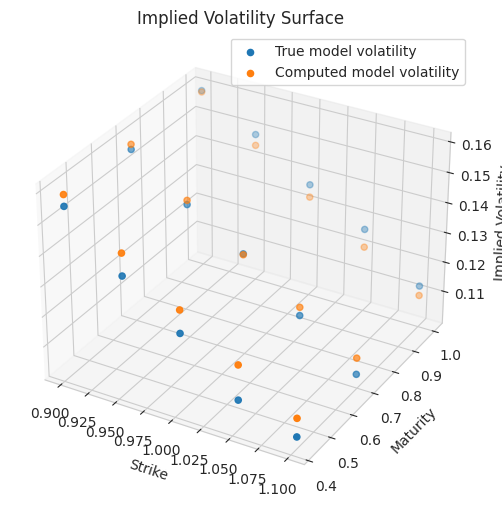

In [353]:
implied_vol = sigma_func(vol_data[:, 0], resx)

sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(vol_data[:, 0], vol_data[:, 1], vol_data[:, 2], label='True model volatility')
ax.scatter(vol_data[:, 0], vol_data[:, 1], est_vol, label='Computed model volatility')
ax.legend()
ax.set_title('Implied Volatility Surface')
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Implied Volatility')
plt.show()

I used 3D scatterplot here to show the difference between the True model volatility and computed model volatility. There is a overlapping section, but it is not drawn well when I use `plot_trisurf` function.

The true model volatility changes not only by the change of the strike price, but by the change of the maturity as well. However, the computed model volatility does not seems to show much change with the change of the maturity. Maybe this is because the local volatility model that we used to approximate the True model volatility did not depend on time, but only required a stock price to calculate the estimated sigma. 

Still, the estimation of the volatility is quite close. 